# Import packages

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import xgboost as xgb
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import openpyxl
import os
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=UserWarning)
import pgeocode
from geopy.distance import geodesic
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb

from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import root_mean_squared_error

# Read the excel files
File including original Concentration, facilities details and distances

##### Read files

In [105]:
file_path = '/Users/leichen/Desktop/WasteWater/data/Trace Organics Full.xlsx'
all_sheets = pd.read_excel(file_path, sheet_name=None, skiprows=3)
all_data = []
sheets_to_exclude = ['Manhole 1', 'Manhole 2','Manhole 3']
file_path1 = '/Users/leichen/Desktop/WasteWater/data/Facilities.xlsx'
Facilities = pd.read_excel(file_path1, header=0)
#Facilities['Population']=Facilities['Population']/1000
Facilities['DailyFlow']=Facilities['DailyFlow']*3.78541
file_path2 = '/Users/leichen/Desktop/WasteWater/data/Analytes.xlsx'
Analytes = pd.read_excel(file_path2, header=0)
file_path3 = '/Users/leichen/Desktop/WasteWater/data/ZipCodes.xlsx'
Zips = pd.read_excel(file_path3,header=0)

##### Calculate the distance from the center of each facility to the center of Las Vegas

In [106]:
nomi = pgeocode.Nominatim('us')  # 'us' for United States
facilityList = []
distanceList = []
 
# Calculate the centroid (center of the group)
def calculate_centroid(coords):
    lats, longs = zip(*coords)
    return (np.mean(lats), np.mean(longs))

las_vegas_coords = (36.1699, -115.1398)
    
for k in Zips['Facility'].unique(): 
    zip_codes_group = Zips[Zips['Facility']==k]
    zip_group = [(nomi.query_postal_code(z).latitude, nomi.query_postal_code(z).longitude) for z in zip_codes_group['ZipCode']]
    centroid = calculate_centroid(zip_group)
    # globals()f'zip_codes_{k}' = zip_group
    distance_to_las_vegas = geodesic(centroid, las_vegas_coords).kilometers
    facilityList.append(k)
    distanceList.append(distance_to_las_vegas)
    zip_distances = pd.DataFrame({
        'Facility': facilityList,
        'Distance': distanceList
    })
    print(f"Centroid of Group {k}:", centroid)
    print(f"Distance between the two centroids: {distance_to_las_vegas:.3f} km")

Centroid of Group Facility_1: (36.10901304347825, -115.17888260869564)
Distance between the two centroids: 7.617 km
Centroid of Group Facility_2: (35.94515, -115.14779999999999)
Distance between the two centroids: 24.949 km
Centroid of Group Facility_3: (36.20858947368422, -115.23982105263157)
Distance between the two centroids: 9.968 km
Centroid of Group Facility_4A: (36.047666666666665, -114.94993333333333)
Distance between the two centroids: 21.822 km
Centroid of Group Facility_4B: (36.03556666666666, -115.069)
Distance between the two centroids: 16.212 km
Centroid of Group Facility_5: (36.27775, -115.1738625)
Distance between the two centroids: 12.353 km
Centroid of Group Facility_6: (35.9727, -114.8344)
Distance between the two centroids: 35.152 km
Centroid of Group Facility_4: (36.04161666666666, -115.00946666666668)
Distance between the two centroids: 18.448 km


# Pre-process & merge the data files

In [107]:
for date, df in all_sheets.items():
    if date not in sheets_to_exclude:
        # Select the relevant columns: Analyte and Facilities (3rd column onwards)
        df_relevant = df.iloc[:, [1]+list(range(3,11))]  # 1st, 3rd to 10th columns
        
        # Rename the columns for ease of reference
        df_relevant.columns = ['Analyte', 'Facility_1', 'Facility_2', 'Facility_3', 'Facility_4', 'Facility_4A', 'Facility_4B', 'Facility_5', 'Facility_6']
        
        # Melt the DataFrame to convert wide format to long format
        df_melted = df_relevant.melt(id_vars=['Analyte'], var_name='Facility', value_name='Consumption')
        
        # Add the 'Date' column (sheet name, representing the date)
        df_melted['Date'] = date
        
        # Append the transformed DataFrame to the list
        all_data.append(df_melted)

# Concatenate all the DataFrames into one
final_df = pd.concat(all_data, ignore_index=True)
final_df['Consumption'] = final_df['Consumption'].astype(str)
final_df['Consumption']= pd.to_numeric(final_df['Consumption'].str.replace('<', ''), errors='coerce')
final_df['Date']=pd.to_datetime(final_df['Date'],format = '%m_%d_%y')

##### merge the files

In [108]:
final_data = pd.merge(final_df,Facilities,on='Facility')
final_data = pd.merge(final_data, Analytes, on='Analyte',how='left')
final_data = pd.merge(final_data, zip_distances,on='Facility',how = 'left')

###### calculate the consumption, index the date

In [109]:
#final_data['Consump1']=(final_data['Consumption']*final_data['CF']*final_data['DailyFlow'])/(final_data['Population'])
final_data['Consump1']=(final_data['Consumption']*final_data['DailyFlow'])/(final_data['Population'])
final_data1 = final_data.copy()
final_data1.index = pd.to_datetime(final_data1['Date'])

###### Functions
1. create_lag: create previous consumption & consumption two months ago
2. create_features: date features

In [110]:
# def create_lag(data, cov,lag):
#     for i in range(1, lag+1):
#         data[f'lag_{i}'] = data.groupby(cov)['Consump1'].shift(i)
#     return data
# #create the lag group by facility


def create_lag(data, cov, lag):
    # Check if 'cov' is a single column or a list, and handle both cases
    if isinstance(cov, str):
        cov = [cov]  # Convert to a list if it's a single column name
    
    # Loop over the specified lags and create lagged columns
    for i in range(1, lag + 1):
        data[f'lag_{i}'] = data.groupby(cov)['Consump1'].shift(i)
    
    return data

In [111]:
# d1 = create_lag(final_data1, ['Facility','Analyte'],1)
# d2 = d1.sort_values(by=['Analyte', 'Facility'], ascending=[True, True])
# d2.to_excel('/Users/leichen/Desktop/WasteWater/results/2.xlsx', index=False)

In [112]:
def create_features(df):
    """
    Create time-based features such as hour of the day, day of the week, etc.
    """
    df.index = pd.to_datetime(df.index)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    return df

# Create datasets 

##### Run to create orignal datasets
1. Analyte Datasets : anayltes across 
2. Analyte_Facility Datasets

In [113]:
analyte_names = final_data1['Analyte'].unique()
facility_names = Facilities['Facility'].unique()

# def create_datasets_by_analytes(df):
#     data_analyte = df[df['Analyte']==analyte]
#     data_analyte = create_lag(data_analyte, 'Facility',1)
#     data_analyte = create_lag(data_analyte, 'Facility',2) 
#     data_analyte = data_analyte.dropna(subset=['lag_1','lag_2'])
#     data_analyte = create_features(data_analyte)
#     globals()[f"data_{analyte}"] = data_analyte
#     for facility in facility_names:
#         data_facility = data_analyte[data_analyte['Facility']==facility]
#         globals()[f"data_{analyte}_{facility}"] = data_facility


for analyte in analyte_names:
    data_analyte = final_data1[final_data1['Analyte'] == analyte]
    data_analyte = create_lag(data_analyte, 'Facility',1)
    data_analyte = create_lag(data_analyte, 'Facility',2) 
    data_analyte= data_analyte.dropna(subset=['lag_1','lag_2'])
    data_analyte = create_features(data_analyte)
    globals()[f"data_{analyte}"] = data_analyte
    for facility in facility_names:
        data_facility = data_analyte[data_analyte['Facility']==facility]
        globals()[f"data_{analyte}_{facility}"] = data_facility

##### Create functions
1. split_train_test : split the training datasets
2. x_y: give X_training, Y_training, X_test, Y_test
3. xgb_based: build base XGB model
4. naive_forecast: build naive model
5. plot_pred_true: plots compare predicted values vs True values
6. plot_difference: plots the difference between naive rmse - xgb rmse 

In [114]:
def split_train_test(df):
    train_size = int(len(df)*0.8)
    split_date = df.iloc[:train_size].index[-1]
    train = df.loc[df.index<= split_date]
    test = df.loc[df.index>split_date]
    return train,test

In [115]:
def x_y(df,features, target):
    train,test = split_train_test(df)
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    return X_train,y_train, X_test, y_test

In [116]:
def xgb_based(df,a,f,features,target):
    reg = xgb.XGBRegressor(base_score=0.5,booster = 'gbtree',n_estimators=1000, early_stopping_rounds=50, max_depth=3, learning_rate=0.01, objective='reg:linear')
    reg.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    test['xgb_pred'] = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(test['Consump1'], test['xgb_pred']))
    return test, score    

In [117]:
def naive_forecast(train, test):
    # Forecast for each time step is simply the last value from the training data
    rmse_naive = np.sqrt(mean_squared_error(test['Consump1'], test['lag_1']))
    return rmse_naive

In [118]:
def plot_pred_true(df,test,a,f,path,method1,method2):
    os.makedirs(f'/Users/leichen/Desktop/WasteWater/plots/{path}/{a}', exist_ok=True) 
    fig, ax = plt.subplots(1, 1, figsize=(10, 5)) 
    ax =df['Consump1'].plot(figsize=(15,5),style='o-')
    test[f'{method1}_pred'].plot(ax=ax, style='o-')
    test['lag_1'].plot(ax = ax,style = 'o-')
    plt.legend(['True', f'{method1}_pred',f'{method2}_pred'])
    plt.text(1, 1, f'{method1}_rmse = {round(score_xgb,4)}, \n{method2}_rmse= {round(score_naive,4)}', fontsize=12, color='blue', ha='right', va='top', transform=plt.gca().transAxes)
    ax.set_title(f'Raw Data and prediction data of {a}_{f}')
    plt.savefig(f'/Users/leichen/Desktop/WasteWater/plots/{path}/{a}/{a}_{f}.png')
    plt.show()         

In [119]:
def plot_difference(df, method):
    fig, ax = plt.subplots(1, 1, figsize=(20, 30)) 
    ax =df['Difference'].plot(figsize=(15,5),style='o-')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax.set_title(f'Naive rmse - XGB rmse: all cases in this plot represent that {method} methods has smaller rmse')
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(0.0005))
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df.index, rotation=45, ha='right') 
    plt.text(1, 1, f'{len(df)} cases in total', fontsize=12, color='blue', ha='right', va='bottom', transform=plt.gca().transAxes)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Models

##### 1. Model with rmse output
features: month, quarter, weekofyear, lag_1, lag_2

In [120]:
# Initialize empty lists to store the values
xgb_list = []
naive_list = []
Analyte_list = []
Faiclity_list = []
AF_index = []
features = ['month', 'quarter', 'weekofyear','lag_1','lag_2']
target = 'Consump1'

for a in analyte_names:
    for f in facility_names:
        data_input=globals()[f"data_{a}_{f}"].copy()
        train, test = split_train_test(data_input)
        X_train,y_train, X_test, y_test = x_y(data_input,features,target)
        test_xgb,score_xgb = xgb_based(data_input,a,f,features,target)
        score_naive = naive_forecast(train, test)
        naive_list.append(score_xgb)
        xgb_list.append(score_naive)
        Analyte_list.append(f'{a}')
        Faiclity_list.append(f'{f}')
        AF_index.append(f'{a}_{f}')
        df_rmse = pd.DataFrame({
            'id': AF_index,
            'Analyte': Analyte_list,
            'Facility': Faiclity_list,
            'XGB_rmse': xgb_list,
            'Naive_rmse': naive_list
        })
        df_rmse['smaller'] = df_rmse.apply(lambda row: 'xgb' if row['XGB_rmse'] < row['Naive_rmse'] else 'naive', axis=1)
        df_rmse['Difference'] = df_rmse['Naive_rmse']-df_rmse['XGB_rmse']
        df_rmse.to_excel('/Users/leichen/Desktop/WasteWater/results/rmse_comparison.xlsx', index=False)

[0]	validation_0-rmse:92.60637	validation_1-rmse:87.27987
[100]	validation_0-rmse:42.31857	validation_1-rmse:33.92619
[200]	validation_0-rmse:22.40426	validation_1-rmse:12.43979
[300]	validation_0-rmse:13.17120	validation_1-rmse:3.60950
[372]	validation_0-rmse:9.56069	validation_1-rmse:3.81040
[0]	validation_0-rmse:45.84433	validation_1-rmse:43.70719
[100]	validation_0-rmse:21.53740	validation_1-rmse:18.57936
[200]	validation_0-rmse:12.00730	validation_1-rmse:7.14105
[300]	validation_0-rmse:7.18070	validation_1-rmse:6.24729
[343]	validation_0-rmse:5.86295	validation_1-rmse:6.33799
[0]	validation_0-rmse:29.46065	validation_1-rmse:36.28139
[100]	validation_0-rmse:12.55656	validation_1-rmse:15.68045
[200]	validation_0-rmse:5.90103	validation_1-rmse:5.68306
[300]	validation_0-rmse:3.08887	validation_1-rmse:2.84244
[352]	validation_0-rmse:2.27651	validation_1-rmse:3.22811
[0]	validation_0-rmse:57.50752	validation_1-rmse:53.99799
[100]	validation_0-rmse:26.87352	validation_1-rmse:21.13230
[2

In [ ]:
features = ['month', 'quarter', 'weekofyear','lag_1','lag_2']
target = 'Consump1'

for a in analyte_names:
    for f in facility_names:
        data_input=globals()[f"data_{a}_{f}"].copy()
        train, test = split_train_test(data_input)
        X_train,y_train, X_test, y_test = x_y(data_input,features,target)
        test_xgb,score_xgb = xgb_based(data_input,a,f,features,target)
        
        score_naive = naive_forecast(train, test)
        plot_pred_true(data_input,test_xgb,a,f,'prediction_true','xgb','naive')
        # data_input_m = data_input.merge(test['xgb_pred'], how='left', left_index=True, right_index=True)

##### 2. Model with distance added

In [127]:
# Initialize empty lists to store the values
xgb_list = []
naive_list = []
Analyte_list = []
features = ['month', 'quarter', 'weekofyear','lag_1','lag_2','Distance']
target = 'Consump1'

for a in analyte_names:
    data_input=globals()[f"data_{a}"].copy()
    # data_input = data_input[data_input['Facility']!='Facility_4']
    train, test = split_train_test(data_input)
    X_train,y_train, X_test, y_test = x_y(data_input,features,target)
    test_xgb,score_xgb = xgb_based(data_input,a,'',features,target)
    score_naive = naive_forecast(train, test)
    naive_list.append(score_naive)
    xgb_list.append(score_xgb)
    Analyte_list.append(f'{a}')
    df_rmse = pd.DataFrame({
        'Analyte': Analyte_list,
        'XGB_rmse': xgb_list,
        'Naive_rmse': naive_list
    })
    df_rmse['smaller'] = df_rmse.apply(lambda row: 'xgb' if row['XGB_rmse'] < row['Naive_rmse'] else 'naive', axis=1)
    df_rmse['Difference'] = df_rmse['Naive_rmse']-df_rmse['XGB_rmse']
    df_rmse.to_excel('/Users/leichen/Desktop/WasteWater/results/rmse_comparison_Distance.xlsx', index=False)

[0]	validation_0-rmse:63.00614	validation_1-rmse:65.87265
[100]	validation_0-rmse:28.20155	validation_1-rmse:28.54018
[200]	validation_0-rmse:16.93264	validation_1-rmse:18.30542
[300]	validation_0-rmse:13.60254	validation_1-rmse:15.39505
[400]	validation_0-rmse:12.13665	validation_1-rmse:14.97568
[424]	validation_0-rmse:11.88565	validation_1-rmse:15.05134
[0]	validation_0-rmse:0.47728	validation_1-rmse:0.47655
[100]	validation_0-rmse:0.17598	validation_1-rmse:0.17522
[200]	validation_0-rmse:0.06531	validation_1-rmse:0.06446
[300]	validation_0-rmse:0.02498	validation_1-rmse:0.02454
[400]	validation_0-rmse:0.01065	validation_1-rmse:0.01141
[500]	validation_0-rmse:0.00603	validation_1-rmse:0.00867
[600]	validation_0-rmse:0.00470	validation_1-rmse:0.00804
[700]	validation_0-rmse:0.00422	validation_1-rmse:0.00796
[800]	validation_0-rmse:0.00388	validation_1-rmse:0.00793
[900]	validation_0-rmse:0.00363	validation_1-rmse:0.00793
[914]	validation_0-rmse:0.00360	validation_1-rmse:0.00794
[0]	va

### Add Categorical features into the model

##### 1. One-hot encoding

In [131]:
# Initialize empty lists to store the values
xgb_list = []
naive_list = []
Analyte_list = []
facility_features = [f'Facility_{i}' for i in facility_names]
features = ['month', 'quarter', 'weekofyear','lag_1','lag_2']
features.extend(facility_features)
target = 'Consump1'

# One-hot encoding

for a in analyte_names:
    data_input=globals()[f"data_{a}"].copy()
    data_input = pd.get_dummies(data_input,columns = ['Facility'])# One-hot encode the categorical feature
    train, test = split_train_test(data_input)
    X_train,y_train, X_test, y_test = x_y(data_input,features,target)
    test_xgb,score_xgb = xgb_based(data_input,a,'',features,target)
    score_naive = naive_forecast(train, test)
    naive_list.append(score_naive)
    xgb_list.append(score_xgb)
    Analyte_list.append(f'{a}')
    df_rmse = pd.DataFrame({
        'Analyte': Analyte_list,
        'XGB_rmse': xgb_list,
        'Naive_rmse': naive_list
    })
    df_rmse['smaller'] = df_rmse.apply(lambda row: 'xgb' if row['XGB_rmse'] < row['Naive_rmse'] else 'naive', axis=1)
    df_rmse['Difference'] = df_rmse['Naive_rmse']-df_rmse['XGB_rmse']
    df_rmse.to_excel('/Users/leichen/Desktop/WasteWater/results/rmse_comparison2.xlsx', index=False)


[0]	validation_0-rmse:63.00681	validation_1-rmse:65.86392
[100]	validation_0-rmse:28.23880	validation_1-rmse:27.83905
[200]	validation_0-rmse:16.80920	validation_1-rmse:17.60130
[300]	validation_0-rmse:13.04319	validation_1-rmse:15.38412
[396]	validation_0-rmse:11.53228	validation_1-rmse:15.02080
[0]	validation_0-rmse:0.47728	validation_1-rmse:0.47655
[100]	validation_0-rmse:0.17598	validation_1-rmse:0.17522
[200]	validation_0-rmse:0.06531	validation_1-rmse:0.06446
[300]	validation_0-rmse:0.02496	validation_1-rmse:0.02446
[400]	validation_0-rmse:0.01060	validation_1-rmse:0.01146
[500]	validation_0-rmse:0.00587	validation_1-rmse:0.00930
[600]	validation_0-rmse:0.00455	validation_1-rmse:0.00907
[700]	validation_0-rmse:0.00415	validation_1-rmse:0.00889
[800]	validation_0-rmse:0.00391	validation_1-rmse:0.00892
[808]	validation_0-rmse:0.00390	validation_1-rmse:0.00893
[0]	validation_0-rmse:0.30036	validation_1-rmse:0.29801
[100]	validation_0-rmse:0.11756	validation_1-rmse:0.11382
[200]	vali

##### 2. Naive XGB categorical support

In [137]:
# Initialize empty lists to store the values
xgb_list = []
naive_list = []
Analyte_list = []
# facility_features = [f'Facility_{i}' for i in facility_names]
features = ['month', 'quarter', 'weekofyear','lag_1','lag_2','Facility']
# features.extend(facility_features)
target = 'Consump1'


for a in analyte_names:
    data_input=globals( )[f"data_{a}"].copy()
    data_input['Facility'] = data_input['Facility'].astype('category')
    train, test = split_train_test(data_input)
    X_train,y_train, X_test, y_test = x_y(data_input,features,target)
    model = xgb.XGBRegressor(enable_categorical=True, tree_method='gpu_hist' if 'category' in X_train.dtypes else 'auto')
    model.fit(X_train,y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)
    test['xgb_pred'] = model.predict(X_test)
    score_xgb = np.sqrt(mean_squared_error(test['Consump1'], test['xgb_pred']))
    score_naive = naive_forecast(train, test)
    naive_list.append(score_naive)
    xgb_list.append(score_xgb)
    Analyte_list.append(f'{a}') 
    df_rmse = pd.DataFrame({
        'Analyte': Analyte_list,
        'XGB_rmse': xgb_list,
        'Naive_rmse': naive_list
    })
    df_rmse['smaller'] = df_rmse.apply(lambda row: 'xgb' if row['XGB_rmse'] < row['Naive_rmse'] else 'naive', axis=1)
    df_rmse['Difference'] = df_rmse['Naive_rmse']-df_rmse['XGB_rmse']
    df_rmse.to_excel('/Users/leichen/Desktop/WasteWater/results/rmse_comparison3.xlsx', index=False)


[0]	validation_0-rmse:23.35576	validation_1-rmse:23.21132
[99]	validation_0-rmse:0.01382	validation_1-rmse:17.93266
[0]	validation_0-rmse:0.00692	validation_1-rmse:0.00661
[99]	validation_0-rmse:0.00136	validation_1-rmse:0.00575
[0]	validation_0-rmse:0.05787	validation_1-rmse:0.04396
[99]	validation_0-rmse:0.00138	validation_1-rmse:0.03255
[0]	validation_0-rmse:0.16136	validation_1-rmse:0.15835
[99]	validation_0-rmse:0.00193	validation_1-rmse:0.14756
[0]	validation_0-rmse:0.24858	validation_1-rmse:0.36654
[99]	validation_0-rmse:0.00166	validation_1-rmse:0.20012
[0]	validation_0-rmse:16.58440	validation_1-rmse:10.68985
[99]	validation_0-rmse:0.00837	validation_1-rmse:8.35238
[0]	validation_0-rmse:0.01425	validation_1-rmse:0.01480
[99]	validation_0-rmse:0.00133	validation_1-rmse:0.02354
[0]	validation_0-rmse:0.10457	validation_1-rmse:0.21086
[99]	validation_0-rmse:0.00139	validation_1-rmse:0.13857
[0]	validation_0-rmse:0.02328	validation_1-rmse:0.01883
[99]	validation_0-rmse:0.00185	vali

##### 3. LightGBM

In [146]:
categorical_features = ['Facility']
# Initialize empty lists to store the values
xgb_list = []
naive_list = []
Analyte_list = []
features = ['month', 'quarter', 'weekofyear','lag_1','lag_2','Facility']
target = 'Consump1'


for a in analyte_names:
    data_input=globals()[f"data_{a}"].copy()
    data_input['Facility'] = data_input['Facility'].astype('category')
    train, test = split_train_test(data_input)
    X_train,y_train, X_test, y_test = x_y(data_input,features,target)
    # Convert data to LightGBM Dataset format and specify categorical features
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, categorical_feature=categorical_features)

    # Define parameters for LightGBM
    params = {
        'objective': 'regression',  # Use 'regression' for predicting continuous values
        'metric': 'rmse',           # Use root mean squared error for evaluation
        'boosting_type': 'gbdt',
        'learning_rate': 0.1,
        'verbose': -1,
    }
    model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    callbacks=[early_stopping(stopping_rounds=10), log_evaluation(10)]
    )
 
    test['xgb_pred'] = model.predict(X_test)
    score_xgb = np.sqrt(mean_squared_error(test['Consump1'], test['xgb_pred']))
    score_naive = naive_forecast(train, test)
    naive_list.append(score_naive)
    xgb_list.append(score_xgb)
    Analyte_list.append(f'{a}') 
    df_rmse = pd.DataFrame({
        'Analyte': Analyte_list,
        'XGB_rmse': xgb_list,
        'Naive_rmse': naive_list
    })
    df_rmse['smaller'] = df_rmse.apply(lambda row: 'xgb' if row['XGB_rmse'] < row['Naive_rmse'] else 'naive', axis=1)
    df_rmse['Difference'] = df_rmse['Naive_rmse']-df_rmse['XGB_rmse']
    df_rmse.to_excel('/Users/leichen/Desktop/WasteWater/results/rmse_comparison4.xlsx', index=False)

    # # Evaluate the model
    # rmse = root_mean_squared_error(y_test, y_pred, squared=False)
    # print(f"Root Mean Squared Error: {rmse}")

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 19.8537	valid_1's rmse: 17.3002
[20]	training's rmse: 17.5145	valid_1's rmse: 14.3251
[30]	training's rmse: 16.7942	valid_1's rmse: 13.4624
[40]	training's rmse: 16.4706	valid_1's rmse: 13.2911
[50]	training's rmse: 16.1537	valid_1's rmse: 13.1658
[60]	training's rmse: 15.8046	valid_1's rmse: 13.3366
Early stopping, best iteration is:
[50]	training's rmse: 16.1537	valid_1's rmse: 13.1658
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.00700455	valid_1's rmse: 0.00542359
[20]	training's rmse: 0.00660174	valid_1's rmse: 0.00506539
[30]	training's rmse: 0.00641883	valid_1's rmse: 0.00503021
Early stopping, best iteration is:
[25]	training's rmse: 0.00650301	valid_1's rmse: 0.00500891
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 0.0449346	valid_1's rmse: 0.0277176
[20]	training's rmse: 0.0381421	valid_1's rmse: 0.0214505
[30]	training

# Visualize the difference

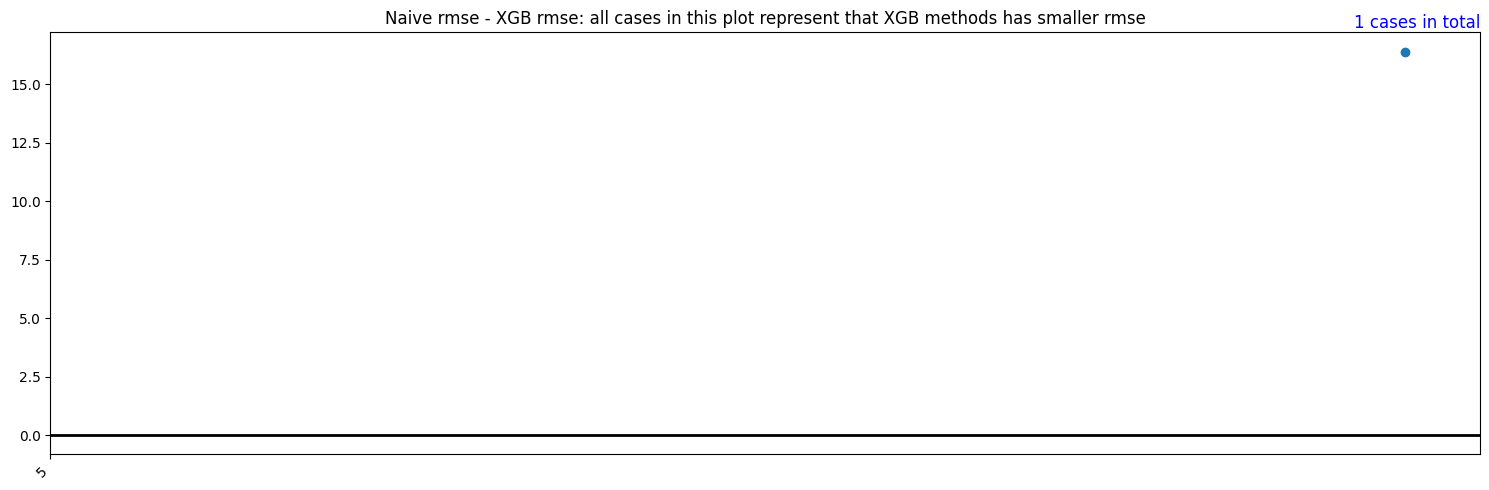

In [141]:
# df_rmse.index = df_rmse['id']
df_sorted = df_rmse.sort_values(by='Difference')
# n = 312 

df_sorted1 = df_sorted[df_sorted['XGB_rmse']!=0]

group0 = df_sorted[df_sorted['XGB_rmse']==0]
group1 = df_sorted1[(df_sorted1['Difference']<-0.8) & (df_sorted['Difference']>-40)]# First group
group2 = df_sorted1[(df_sorted1['Difference']>=-0.8) & (df_sorted1['Difference']<-0.01)]
group3 = df_sorted1[(df_sorted1['Difference']>=-0.01) & (df_sorted1['Difference']<=0)]
group6 = df_sorted1[(df_sorted1['Difference']>0) & (df_sorted1['Difference']<0.001)]
group7 = df_sorted1[(df_sorted1['Difference']>0.001) & (df_sorted1['Difference']<0.1)]
group8 = df_sorted1[(df_sorted1['Difference']>0.1) & (df_sorted1['Difference']<8)]
group9 = df_sorted1[(df_sorted1['Difference']>8)]


plot_difference(group9,'XGB')


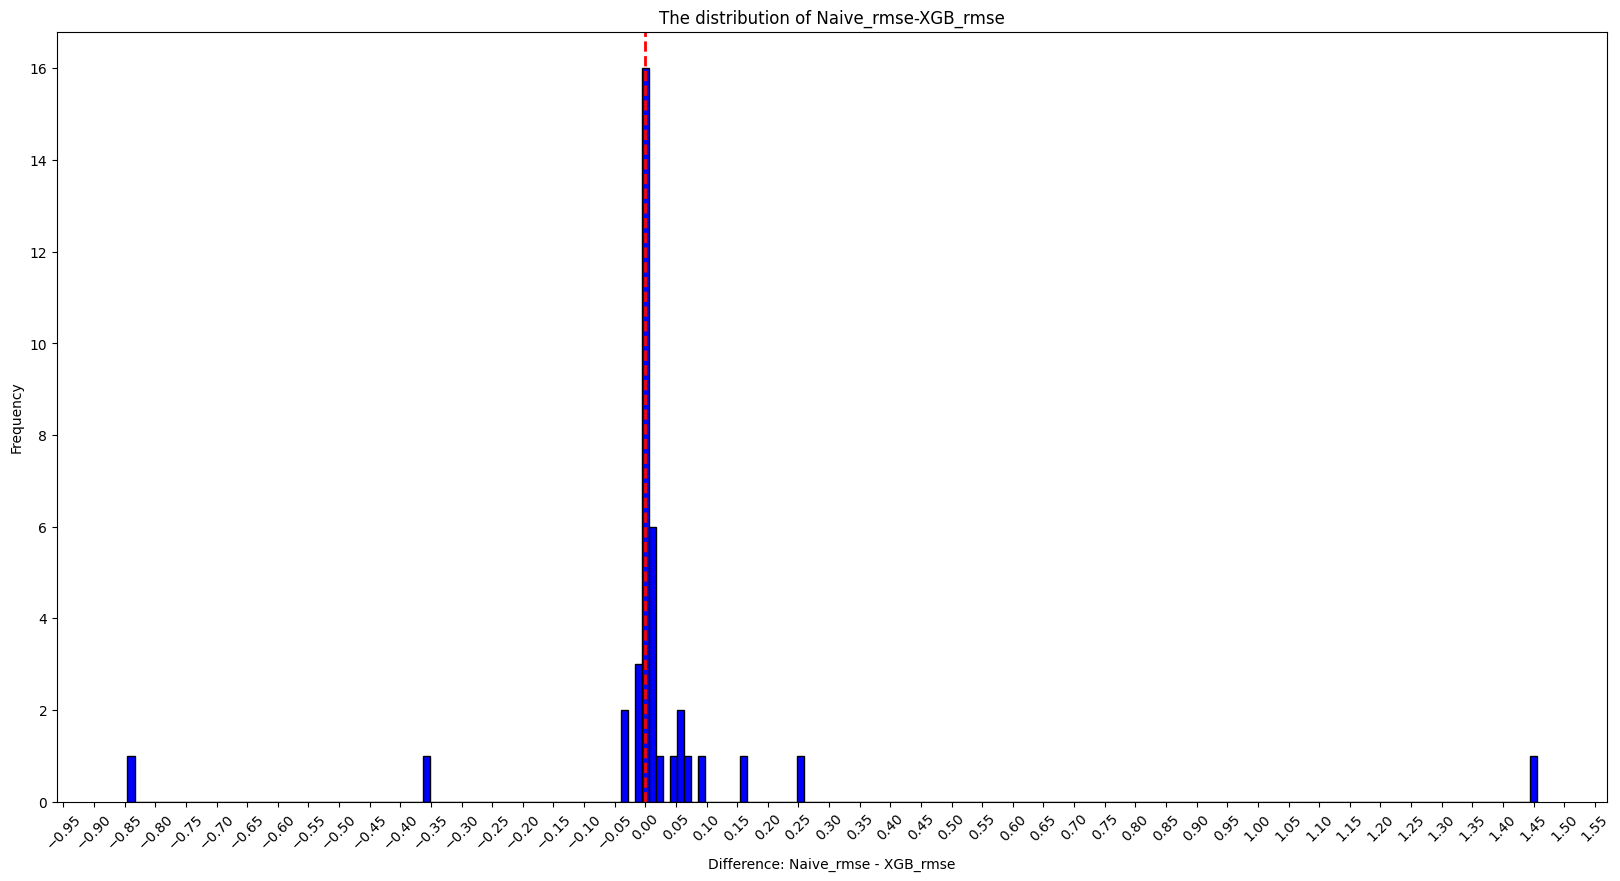

In [144]:
# Create a histogram
# plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(1, 1, figsize=(20, 10)) 
df_for_draw1 = df_sorted1[(df_sorted1['Difference']>=-2) & (df_sorted1['Difference']<=2)]
# df_for_draw1 = df_sorted1[(df_sorted1['Difference']>=-6) & (df_sorted1['Difference']<=6)]
plt.hist(df_for_draw1['Difference'], bins=200, color='blue', edgecolor='black')

plt.title('The distribution of Naive_rmse-XGB_rmse')
plt.xticks(np.arange(min(df_for_draw1['Difference']), max(df_for_draw1['Difference']), .5))
plt.xticks(rotation=45)
plt.xlabel('Difference: Naive_rmse - XGB_rmse')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))  # Set tick interval to 0.5
plt.ylabel('Frequency')

# Show the plot
plt.show()


##### No run

In [145]:
# # Loop over each facility name
for f in facility_names:
    # Filter DataFrame for each facility
    df_tm = df_rmse[df_rmse['Facility'] == f]
    
    # Create a new figure and axes for each plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))  # Set the figure size here

    # Plot 'XGB_rmse' and 'Naive_rmse' on the same axes
    ax = df_tm['XGB_rmse'].plot(ax=ax, style='o-', label='XGB rmse')  # Plot XGB_rmse
    df_tm['Naive_rmse'].plot(ax=ax, style='o-', label='Naive rmse')   # Plot Naive_rmse

    # Ensure that all x-axis labels (index) are shown
    ax.set_xticks(range(len(df_tm)))  # Set x-ticks for all index positions
    ax.set_xticklabels(df_tm.index, rotation=45, ha='right')  # Use the index as labels and rotate for better readability

    # Set the legend and title
    plt.legend(['XGB rmse', 'Naive rmse'])
    ax.set_title(f'XGB rmse vs. Naive rmse_{f}')
    
    # Save each plot as a separate file
    plt.savefig(f'/Users/leichen/Desktop/WasteWater/plots/rmse/{f}.png')
    
    # Show the plot
    plt.show()
    

# New Trial

In [ ]:
# Fine tune LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
}

In [ ]:
# Initialize empty lists to store the values
xgb_list = []
naive_list = []
features = ['month', 'quarter', 'weekofyear','lag_1','lag_2','Distance','DetailedCat']
target = 'Consump1'

data_input=final_data1.copy()
data_input['DetailedCat'] = data_input['DetailedCat'].astype('category')
train, test = split_train_test(data_input)
X_train,y_train, X_test, y_test = x_y(data_input,features,target)
test_xgb,score_xgb = xgb_based(data_input,a,'',features,target)
score_naive = naive_forecast(train, test)
naive_list.append(score_xgb)
xgb_list.append(score_naive)
    Analyte_list.append(f'{a}')
    Faiclity_list.append(f'{f}')
    AF_index.append(f'{a}_{f}')
    df_rmse = pd.DataFrame({
        'Analyte': Analyte_list,
        'XGB_rmse': xgb_list,
        'Naive_rmse': naive_list
    })
    df_rmse['smaller'] = df_rmse.apply(lambda row: 'xgb' if row['XGB_rmse'] < row['Naive_rmse'] else 'naive', axis=1)
    df_rmse['Difference'] = df_rmse['Naive_rmse']-df_rmse['XGB_rmse']
    df_rmse.to_excel('/Users/leichen/Desktop/WasteWater/results/rmse_comparison1.xlsx', index=False)